In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras import models
from keras import optimizers

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_labels = train[labels].values

In [20]:
examples = pd.DataFrame(["I love you", "You suck", "You are idiot"])
examples.columns = ["comment_text"]

In [4]:
# Parameters
embed_size = 100
max_features = 20000
MAX_SEQUENCE_LENGTH = 100
EPOCH = 5
BATCH_SIZE = 32

In [21]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(train['comment_text']))
train_input = pad_sequences(tokenizer.texts_to_sequences(train['comment_text']), maxlen = MAX_SEQUENCE_LENGTH)
test_input = pad_sequences(tokenizer.texts_to_sequences(test['comment_text']), maxlen = MAX_SEQUENCE_LENGTH)
examples_input = pad_sequences(tokenizer.texts_to_sequences(examples['comment_text']), maxlen = MAX_SEQUENCE_LENGTH)

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HUAWEI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Reference: https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
from nltk.corpus import stopwords
EMBEDDING_FILE = '../data/glove.6B.100d.txt'
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype = 'float32')

def remove_stopwords(old_dict):
    for key in stopwords.words():
        if key in old_dict.keys():
            del old_dict[key]
    return old_dict
    
embedding_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE,encoding="utf8"))

all_embs = np.stack(embedding_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

word_index = tokenizer.word_index
word_index_without_sw = remove_stopwords(word_index)
num_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embed_size))
i = 0
for word in word_index_without_sw.keys():
    if i >= num_words: 
        break
    if word in embedding_index.keys():
        embedding_matrix[i] = embedding_index[word]
    i += 1

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


In [8]:
model = models.Sequential()
model.add(layers.Input(shape = (MAX_SEQUENCE_LENGTH,)))
model.add(layers.Embedding(max_features, embed_size, weights=[embedding_matrix]))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(100, activation = "relu"))
model.add(layers.Dense(100, activation = "relu"))
model.add(layers.Dense(100, activation = "relu"))
model.add(layers.Dense(6, activation = "sigmoid"))

model.summary()
opt = optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer = opt, loss = "binary_crossentropy", metrics = ["accuracy"])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 606       
Total params: 2,030,906
Trainable params: 2,030,906
Non-trainable params: 0
______________________________________________

In [9]:
history = model.fit(train_input, train_labels, batch_size = BATCH_SIZE, epochs = EPOCH, validation_split = 0.2)

Epoch 1/5
3990/3990 [==============================] - 86s 22ms/step - loss: 0.0955 - accuracy: 0.9821 - val_loss: 0.0739 - val_accuracy: 0.9941
Epoch 2/5
3990/3990 [==============================] - 92s 23ms/step - loss: 0.0611 - accuracy: 0.9936 - val_loss: 0.0615 - val_accuracy: 0.9941
Epoch 3/5
3990/3990 [==============================] - 92s 23ms/step - loss: 0.0506 - accuracy: 0.9918 - val_loss: 0.0574 - val_accuracy: 0.9941
Epoch 4/5
3990/3990 [==============================] - 93s 23ms/step - loss: 0.0446 - accuracy: 0.9936 - val_loss: 0.0590 - val_accuracy: 0.9941
Epoch 5/5
3990/3990 [==============================] - 93s 23ms/step - loss: 0.0404 - accuracy: 0.9874 - val_loss: 0.0595 - val_accuracy: 0.9939


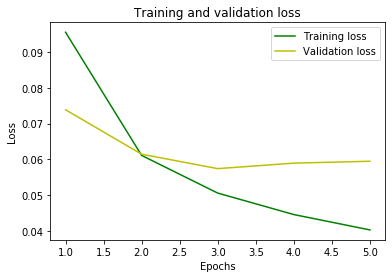

In [27]:
#Reference: https://towardsdatascience.com/machine-learning-recurrent-neural-networks-and-long-short-term-memory-lstm-python-keras-example-86001ceaaebc
import matplotlib.pyplot as plt
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

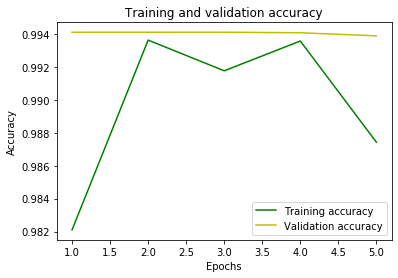

In [11]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
predict_on_test = model.predict(test_input)

In [13]:
out = pd.concat([test["id"], pd.DataFrame(predict_on_test)], axis=1, ignore_index = True)
output_columns = ['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
out.columns = output_columns
submission_file = open("../output/submission_MLP.csv", "w")
out.to_csv('../output/submission_MLP.csv', index = False)
submission_file.close()

In [14]:
out.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.998175,2.278652e-01,0.925310,1.469482e-01,0.891245,3.391344e-01
1,0000247867823ef7,0.000195,3.276327e-09,0.000015,7.815319e-07,0.000012,1.799684e-06
2,00013b17ad220c46,0.000033,2.591831e-10,0.000003,1.078626e-07,0.000002,2.253952e-07
3,00017563c3f7919a,0.000048,5.429896e-10,0.000007,8.027645e-08,0.000004,6.836982e-07
4,00017695ad8997eb,0.000403,1.435239e-08,0.000044,2.442738e-06,0.000029,8.725211e-06


In [25]:
predict_on_examples = model.predict(examples_input)
exmaples_out = pd.concat([examples["comment_text"], pd.DataFrame(predict_on_examples)], axis=1, ignore_index = True)
exmaples_out.columns = ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
exmaples_out

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,I love you,0.054322,0.000195,0.004439,0.003223,0.020316,0.001866
1,You suck,0.999665,0.353211,0.981600,0.002664,0.842352,0.049637
2,You are idiot,0.998914,0.035857,0.781053,0.003399,0.922430,0.005506
